# Import Modules

In [203]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [204]:
# Initialize Plotly for use in the notebook
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [205]:
# Configure Seaborn plot styles: Set background color and use dark grid
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

# Loading Dataset

In [206]:
df = pd.read_excel('/content/Online_Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [208]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [209]:
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
Country,541909,38,United Kingdom,495478


# Handling Missing Values

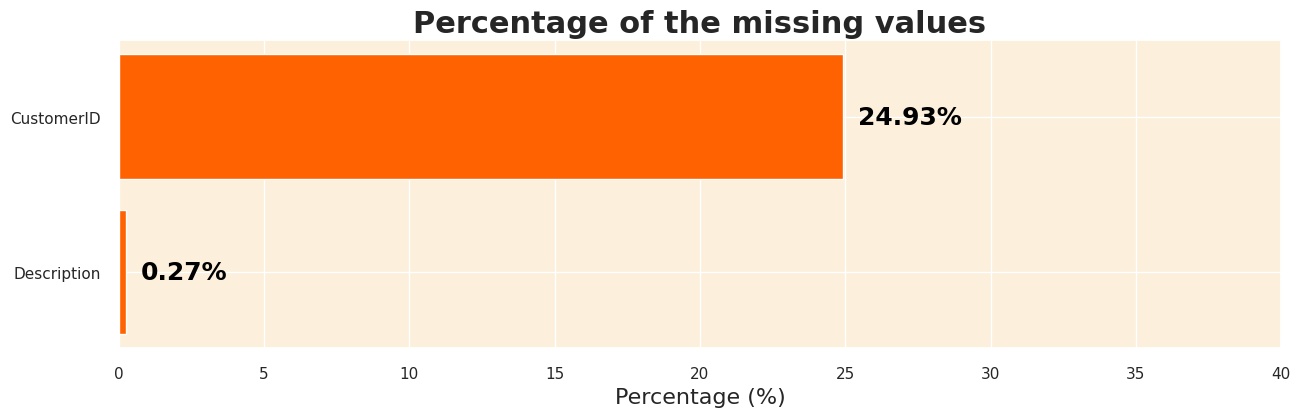

In [210]:
# calculate the percentage of missing values of each column
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

# prepare values
missing_percentage.sort_values(ascending = True, inplace = True)

# plot the barh chart
fig, ax = plt.subplots(figsize = (15, 4))
ax.barh(missing_percentage.index, missing_percentage, color = '#ff6200')

# annote the values and indexes
for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha = 'left', va = 'center',
            fontweight = 'bold', fontsize = 18, color = 'black')

# set x-axis limit
ax.set_xlim([0, 40])

# Add the title and xlabel
plt.title('Percentage of the missing values', fontweight = 'bold', fontsize = 22)
plt.xlabel('Percentage (%)', fontsize = 16)
plt.show()

In [211]:
# Extracting rows with missing values
df[df['CustomerID'].isnull() | df['Description'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom


In [212]:
# removing rows with missing values
df = df.dropna(subset = ['CustomerID', 'Description'])

In [213]:
# verifying the removal of missing values
df.isnull().sum().sum()

0

# Handling Duplicates

In [214]:
# Finding duplicate rows
duplicate_rows = df[df.duplicated(keep = False)]

# Sorting the data by certain columns to see the duplicate rows next to each other
duplicate_rows_sorted = duplicate_rows.sort_values(by = ['InvoiceNo', 'StockCode',
                                                         'Description',
                                                         'CustomerID',
                                                         'Quantity'])

# Displaying the first 10 records
duplicate_rows_sorted.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1,2010-12-01 11:49:00,1.65,17920.0,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1,2010-12-01 11:49:00,1.65,17920.0,United Kingdom


In [215]:
# Displaying the number of duplicate rows
print(f'The dataset contains {df.duplicated().sum()} duplicate rows that needed to be removed.')

# Removing duplicate rows
df.drop_duplicates(inplace = True)

The dataset contains 5225 duplicate rows that needed to be removed.


In [216]:
# Getting the number of rows in the dataframe
df.shape[0]

401604

# Treating Cancelled Transactions

In [217]:
# Filter out the rows with InvoiceNo starting with "C" and Create a new column indicating the transcations status
df['Transcation_Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

# Analyze the characteristics of these rows
cancelled_transcations = df[df['Transcation_Status'] == 'Cancelled']
cancelled_transcations.describe().drop('CustomerID', axis = 1)

,Quantity,UnitPrice
count,8872.000000,8872.000000
mean,-30.774910,18.899512
std,1172.249902,445.190864
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,4.950000
max,-1.000000,38970.000000


In [218]:
# finding the percentage of cancelled transactions
cancelled_percentage = (cancelled_transcations.shape[0] / df.shape[0]) * 100

# printing the percentage of cancelled transactions
print(f'The percentage of cancelled transactions in the dataset is: {cancelled_percentage:.2f}5')

The percentage of cancelled transactions in the dataset is: 2.215


# Correcting StockCode Anomalies

In [219]:
# finding the number of unique stock codes
unique_stock_codes = df['StockCode'].nunique()

# printing the number of unique stock codes
print(f'The number of unique stock code is: {unique_stock_codes}')

The number of unique stock code is: 3684


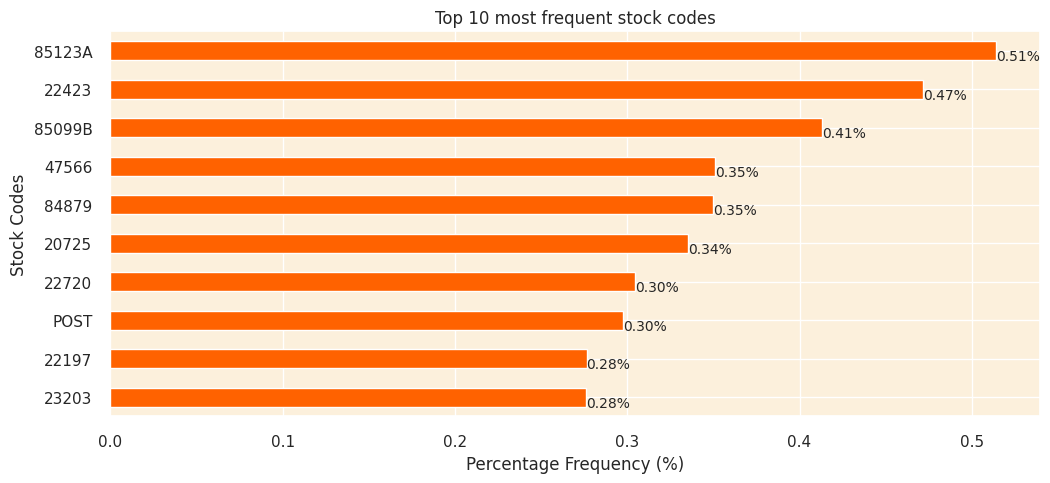

In [220]:
# finding the top 10 most frequent stock codes
top_10_stock_codes = df['StockCode'].value_counts(normalize = True).head(10) * 100

# plotting the top 10 most frequent stock codes
plt.figure(figsize = (12, 5))
top_10_stock_codes.plot(kind = 'barh', color = '#ff6200')

# adding the percentage frequency on the bars
for index, value in enumerate(top_10_stock_codes):
    plt.text(value, index+0.25, f'{value:.2f}%', fontsize = 10)

plt.title('Top 10 most frequent stock codes')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

In [221]:
# Finding the number of numeric characters in each unique stock code
unique_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(
    lambda x: sum(c.isdigit() for c in str(x))).value_counts()

# Printing the value counts for unique stocks
print("Value counts for numeric character frequencies in unique stock codes:")
print("-"*70)
print(numeric_char_counts_in_unique_codes)

Value counts for numeric character frequencies in unique stock codes:
----------------------------------------------------------------------
5    3676
0       7
1       1
dtype: int64


In [222]:
# Finding and printing the stock codes with 0 and 1 numeric characters
anomalous_stock_codes = [code for code in unique_stock_codes
                         if sum(c.isdigit() for c in str(code)) in (0, 1)]

# printing each stock code in a new line
print("Anomalous Stock Codes")
print('-'*22)
for code in anomalous_stock_codes:
    print(code)

Anomalous Stock Codes
----------------------
POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


In [223]:
# Calculating the percentage of records with these stock codes
percentage_anomalous = (df['StockCode'].isin(anomalous_stock_codes).sum() / len(df)) * 100

# printing percentage
print(f'The percentage of records with anomalous stock codes in a dataset is: {percentage_anomalous:.2f}%')

The percentage of records with anomalous stock codes in a dataset is: 0.48%


In [224]:
# Removing rows with anomalous stock codes from the dataset
df = df[~df['StockCode'].isin(anomalous_stock_codes)]

In [225]:
# getting no of rows in a dataframe
df.shape[0]

399689

# Cleaning Description Column

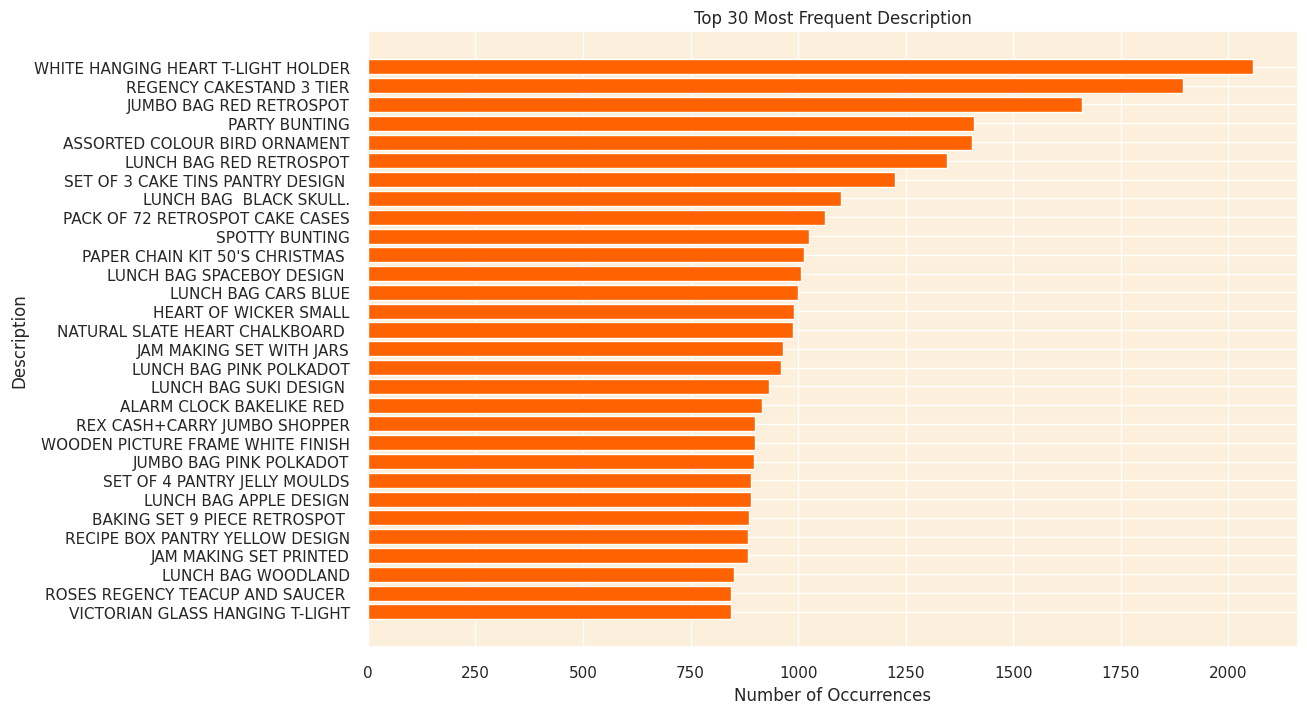

In [226]:
# calculate the occurence of each unique description and sort them
description_counts = df['Description'].value_counts()

# get the top 30 descriptions
top_30_descriptions = description_counts[:30]

# plotting
plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1],
         color = '#ff6200')

# adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Description')
plt.show()

In [227]:
# finding unique descriptions containing lowercase characters
lowercase_descriptions = df['Description'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

# print the unique descriptions containing lowercase characters
print('The unique descriptions containing lowercase characters are:')
print('-'*60)
for desc in lowercase_descriptions:
    print(desc)

The unique descriptions containing lowercase characters are:
------------------------------------------------------------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
NUMBER TILE COTTAGE GARDEN No
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm
High Resolution Image


In [228]:
service_related_descriptions = ['Next Day Carriage', 'High Resolution Image']

# calculate the percentage of records with services-related descriptions
service_related_percentage = df[df['Description'].isin(service_related_descriptions)].shape[0] / df.shape[0] * 100

# print the percentage of records with service-related descriptions
print(f'The percentage of records with service-related descriptions in the dataset is: {service_related_percentage:.2f}%')

# remove rows with service-related information in description
df = df[~df['Description'].isin(service_related_descriptions)]

# standardize the text to uppercase to maintain uniformity across the dataset
df['Description'] = df['Description'].str.upper()

The percentage of records with service-related descriptions in the dataset is: 0.02%


In [229]:
# getting no of rows in dataframe
df.shape[0]

399606

# Treating Zero Unit Prices

In [230]:
# statistical description of the UnitPrice column
df['UnitPrice'].describe()

count    399606.000000
mean          2.904957
std           4.448796
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

In [231]:
df[df['UnitPrice'] == 0].describe()[['Quantity']]

,Quantity
count,33.000000
mean,420.515152
std,2176.713608
min,1.000000
25%,2.000000
50%,11.000000
75%,36.000000
max,12540.000000


In [232]:
# removing records with a unit price of zero to avoid potential data entry errors
df = df[df['UnitPrice'] > 0]

# Outlier Treatment

In [233]:
# resetting the index of the cleaned dataset
df.reset_index(drop = True, inplace = True)

In [234]:
# getting the no of rows in dataframe
df.shape[0]

399573

# Feature Enginnering

RMF Features

Recency (R)

In [235]:
# Convert InvoiceDate to datetime type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Convert InvoiceDate to datatime and extract only the date
df['InvoiceDay'] = df['InvoiceDate'].dt.date

# find the most recent purchase date for each customer
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

# find the most recent date in the entire dataset
most_recent_date = df['InvoiceDay'].max()

# convert InvoiceDay into datetime type before subtraction
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# calculate the number of days since the last purchase for each customer
customer_data['Day_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# remove the InvoiceDay column
customer_data.drop(columns = ['InvoiceDay'], inplace = True)

In [236]:
customer_data.head()

,CustomerID,Day_Since_Last_Purchase
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


Frequency (F)

In [237]:
# calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns = {'InvoiceNo' : 'Total_Transactions'},
                          inplace = True)

# calculate the total number of products purchased by each customer
total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns = {'Quantity' : 'Total_Products_Purchased'},
                                inplace = True)

# merge the new features into customer_data dataframe
customer_data = pd.merge(customer_data, total_transactions, on = 'CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on = 'CustomerID')

# display the first five rows of dataframe
customer_data.head()

,CustomerID,Day_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,12346.0,325,2,0
1,12347.0,2,7,2458
2,12348.0,75,4,2332
3,12349.0,18,1,630
4,12350.0,310,1,196


Monetary (R)

In [238]:
# calculate the total spend by each customer
df['Total_Spend'] = df['UnitPrice'] * df['Quantity']
total_spend = df.groupby('CustomerID')['Total_Spend'].sum().reset_index()

# calculate the average transaction value for each customer
average_transaction_value = total_spend.merge(total_transactions, on = 'CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

# merge the new features into customer_data dataframe
customer_data = pd.merge(customer_data, total_spend, on = 'CustomerID')
customer_data = pd.merge(customer_data,
                         average_transaction_value[['CustomerID', 'Average_Transaction_Value']],
                         on = 'CustomerID')

# display the first five rows
customer_data.head()

,CustomerID,Day_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,12346.0,325,2,0,0.00,0.000000
1,12347.0,2,7,2458,4310.00,615.714286
2,12348.0,75,4,2332,1437.24,359.310000
3,12349.0,18,1,630,1457.55,1457.550000
4,12350.0,310,1,196,294.40,294.400000


Product Diversity

In [239]:
# calculate the number of unique products purchased by each customer
unique_products_purchased = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns = {'StockCode' : 'Unique_Products_Purchased'},
                                 inplace = True)

# merge the new feature into customer_data dataframe
customer_data = pd.merge(customer_data, unique_products_purchased, on = 'CustomerID')

# display the first five rows
customer_data.head()

,CustomerID,Day_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,12346.0,325,2,0,0.00,0.000000,1
1,12347.0,2,7,2458,4310.00,615.714286,103
2,12348.0,75,4,2332,1437.24,359.310000,21
3,12349.0,18,1,630,1457.55,1457.550000,72
4,12350.0,310,1,196,294.40,294.400000,16


Behavioral Features

In [240]:
# extract day of week and hour from InvoiceDate
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# calculate the number of days between consecutive purchase
days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))

average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()

average_days_between_purchases.rename(columns = {'InvoiceDay' : 'Average_Days_Between_Purchases'},
                                      inplace = True)

# find favorite shopping day of the week
favorite_shopping_day = df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name = 'Count')
favorite_shopping_day = favorite_shopping_day.iloc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

# find the favorite shopping hour of the day
favorite_shopping_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name = 'Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

# merge the new features in customer_data dataframe
customer_data = pd.merge(customer_data, average_days_between_purchases, on = 'CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on = 'CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on = 'CustomerID')

# display the first five rows
customer_data.head()

,CustomerID,Day_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16


Geographic Features

In [241]:
df.Country.value_counts(normalize=True).head()

United Kingdom    0.890971
Germany           0.022722
France            0.020402
EIRE              0.018440
Spain             0.006162
Name: Country, dtype: float64

In [242]:
# groupby CustomerID and Country to get the number of transactions per country for each customer
customer_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name = 'Number_of_Transactions')

# get the country with the maximum number of for each customer
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')

# create the binary column indicating whether the customer is from UK or not
customer_main_country['Is_UK'] =  customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

# merging this data with customer_data dataframe
customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'Is_UK']], on = 'CustomerID', how = 'left')

# display the first five rows
customer_data.head()

,CustomerID,Day_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0


In [243]:
# display feature distribution
customer_data['Is_UK'].value_counts()

1    3866
0     416
Name: Is_UK, dtype: int64

Cancellation Insights

In [244]:
# calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# calculate the number of cancelled transactions for each customer
cancelled_transactions = df[df.Transcation_Status == 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns = {'InvoiceNo' : 'Cancellation_Frequency'}, inplace = True)

# merge cancellation frequency into customer_data dataframe
customer_data = pd.merge(customer_data, cancellation_frequency, on = 'CustomerID', how = 'left')

# replace the NaN values with 0
customer_data['Cancellation_Frequency'].fillna(0, inplace = True)

# calculate the cancellation rate
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['InvoiceNo']

# display the first five rows
customer_data.head()

,CustomerID,Day_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0


Seasonality and Trends